### Helper

In [1]:
"""
MODIFIED BY Goragod P. Hosei University
From the work of Francesco Mattioli (https://github.com/Kubasinska/MI-EEG-1D-CNN/blob/9495d00addc95f7045b9031f175cbdcf3abc73d8/dataset_generator/generator.py#L47)
A 1D CNN for high accuracy classiﬁcation in motor imagery EEG-based brain-computer interface
Journal of Neural Engineering (https://doi.org/10.1088/1741-2552/ac4430)
Copyright (C) 2022  Francesco Mattioli, Gianluca Baldassarre, Camillo Porcaro


This program is free software: you can redistribute it and/or modify
it under the terms of the GNU General Public License as published by
the Free Software Foundation, either version 3 of the License, or
(at your option) any later version.

"""
"""
THIS IS THE MAIN GENERATOR
"""

from mne.io import BaseRaw, read_raw_edf, concatenate_raws
from mne.channels import make_standard_montage
from mne.datasets import eegbci
from mne.epochs import Epochs
import numpy as np
import mne
from typing import List, Tuple

from sklearn.preprocessing import minmax_scale
import tensorflow as tf
from scipy.signal import lfilter, butter, filtfilt


SEED = 1
#set seed
np.random.seed(SEED)
exclude =  [38, 88, 89, 92, 100, 104]

ch_list = ['FC5', 'FC3', 'FC1', 'FCZ', 'FC2', 'FC4', 'FC6', 'C5', 
           'C3', 'C1', 'CZ', 'C2', 'C4', 'C6', 'CP5', 'CP3', 'CP1', 
           'CPZ', 'CP2', 'CP4', 'CP6', 'FP1', 'FPZ', 'FP2', 'AF7', 
           'AF3', 'AFZ', 'AF4', 'AF8', 'F7', 'F5', 'F3', 'F1', 'FZ', 
           'F2', 'F4', 'F6', 'F8', 'FT7', 'FT8', 'T7', 'T8', 'T9', 'T10', 
           'TP7', 'TP8', 'P7', 'P5', 'P3', 'P1', 'PZ', 'P2', 'P4', 'P6', 'P8', 
           'PO7', 'PO3', 'POZ', 'PO4', 'PO8', 'O1', 'OZ', 'O2', 'IZ']

def rename_ch(raw:BaseRaw)-> BaseRaw:
    old_ch_name = raw.ch_names
    new_ch_name = [ch.replace('.', '').upper() for ch in old_ch_name]
    new_ch = {key:val for key, val in zip(old_ch_name, new_ch_name)}
    raw.rename_channels(new_ch)
    # print(raw.info['ch_names'])
    return raw

def load_data(subjects:List, runs:List, max_duration: int = 124, chs: List = None) -> List[List[BaseRaw]]:
    all_subject_list = []
    
    # read each subject and each run
    for subject in subjects:
        single_subject_run = []
        for run in runs:
            #create file name
            f = eegbci.load_data(subject, run)
            raw_run = read_raw_edf(f[0], preload=True, verbose=False)
            #Cleanup channel name
            raw_run = rename_ch(raw_run)
            #Change annotaion name
            if np.sum(raw_run.annotations.duration) > max_duration:
                # print("Run %d of subject %d has duration less than %d, cropped" % (run, subject, max_duration))
                raw_run.crop(tmax = max_duration)

            #change annotation from T0,T1 and T2 to more meaningful
            if run in [3, 7, 11]: #Task 1
                for i, annotation in enumerate(raw_run.annotations.description):
                    if annotation == 'T0':
                        raw_run.annotations.description[i] = 'R'
                    if annotation == 'T1':
                        raw_run.annotations.description[i] = 'ML'
                    if annotation == 'T2':
                        raw_run.annotations.description[i] = 'MR'
            if run in [4, 8, 12]: #Task 2
                for i, annotation in enumerate(raw_run.annotations.description):
                    if annotation == 'T0':
                        raw_run.annotations.description[i] = 'R'
                    if annotation == 'T1':
                        raw_run.annotations.description[i] = 'IL'
                    if annotation == 'T2':
                        raw_run.annotations.description[i] = 'IR'
            if run in [5, 9, 13]: #Task 3
                for i, annotation in enumerate(raw_run.annotations.description):
                    if annotation == 'T0':
                        raw_run.annotations.description[i] = 'R'
                    if annotation == 'T1':
                        raw_run.annotations.description[i] = 'MH'
                    if annotation == 'T2':
                        raw_run.annotations.description[i] = 'MF'
            if run in [6, 10, 14]: #Task 4
                for i, annotation in enumerate(raw_run.annotations.description):
                    if annotation == 'T0':
                        raw_run.annotations.description[i] = 'R'
                    if annotation == 'T1':
                        raw_run.annotations.description[i] = 'IH'
                    if annotation == 'T2':
                        raw_run.annotations.description[i] = 'IF'

            #Select channel
            if chs is not None:
                if len(chs) >= 1:
                    raw_run.pick_channels(chs)

            single_subject_run.append(raw_run)
        all_subject_list.append(single_subject_run)
    return all_subject_list



def epochs(raws: List[BaseRaw], exclude_base: bool = False, normal_by_sub = False,
            tmin :int = 0, tmax: int = 4, verbose=False) -> Tuple[np.ndarray, List]:
    xs = []
    ys = []
    ALL_EVENT_ID = dict(R = 0, ML = 1, MR = 2, IL = 3, IR = 4, MH = 5, MF = 6, IH = 7, IF = 8)

    for i, raw in enumerate(raws):
        # create key denpend on the number of exisiting class
        for run in raw:
            event_annotation = np.unique(run.annotations.description)
            event_id = dict.fromkeys(event_annotation, None)
            event_id = {key:val for key,val in zip(ALL_EVENT_ID.keys(), ALL_EVENT_ID.values()) if key in event_annotation}
            if exclude_base:
                del event_id['R']
            # print(event_id, run)
            events, _ = mne.events_from_annotations(run, event_id = event_id, verbose=verbose)
            picks = mne.pick_types(run.info, meg = False, eeg = True, eog = False, exclude = 'bads')
            ep = Epochs(run, events, event_id, tmin, tmax, proj = True, picks = picks, baseline = None, preload = True, verbose=verbose)
            # print(event_id)
            # print(ep.get_data().shape, ep.events.shape)
            data = ep.get_data()
            # if normal_by_sub:
                # normallize(data)
                
            xs.append(eeg_tensor_format(data))
            ys.append(ep.events)            

    return np.concatenate(xs, axis=0), np.concatenate(ys, axis = 0)

def to_one_hot(y, by_sub=False):
    new_array = y.copy()
    total_labels = np.unique(new_array)
    # print(total_labels)
    mapping = {}
    for x in range(len(total_labels)):
        mapping[total_labels[x]] = x
    for x in range(len(new_array)):
        new_array[x] = mapping[new_array[x]]

    return tf.keras.utils.to_categorical(new_array)

def eeg_tensor_format(x:np.ndarray)->np.ndarray:
    return np.transpose(x, (0,2,1)).astype(np.float64)


def butterworth_bpf(data, lowcut, highcut, fs, order = 4):
    nyquist = fs * 0.5
    low = lowcut / nyquist
    high = highcut / nyquist
    if len(data.shape) <= 2:
        np.expand_dims(data, -1)
    print(data.shape)
    b, a = butter(4, [low, high], btype = 'band', output = 'ba', analog = False)
    return filtfilt(b, a, data, axis = 1)

if __name__ == "__main__":
    subject = list(range(1,30))
    runs = [3,5,7,9,11,13] #Movement Left, Right, Left+Right, Foot and Idle

    # d = load_data(subjects=subject, runs=runs, max_duration=120, chs = ['FP1', 'FP2'])
    d = load_data(subjects=subject, runs=runs, max_duration=161)
    X, y = epochs(d, tmax=2)
    y = to_one_hot(y[:,-1])
    print(X.shape, y.shape, X.min(), X.max())

2023-03-09 15:41:03.865244: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-09 15:41:04.443499: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-03-09 15:41:05.825201: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/lib/:/home/capiadmin/anaconda3/envs/ray/lib/:/home/capiadmin/anaconda3/envs/ray/lib/
2023-03-09 15:41:05.825378: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'l

(5220, 321, 64) (5220, 5) -0.000705 0.000803


In [2]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import minmax_scale
target = 2000

# X = butterworth_bpf(X, 0.4, 40, 160)
ch_len = X.shape[2]
x_before_norm = X[target,:,:].copy()
X = X.reshape(X.shape[0], X.shape[1] * X.shape[2])
print ('before normalize = {}, {}'.format(X.min(), X.max()))
X = minmax_scale(X, axis = 1)
print ('after normalize = {}, {}'.format(X.min(), X.max()))
X = X.reshape(X.shape[0], X.shape[1] // ch_len, ch_len)
x_after_norm = X[target,:,:].copy()

x_train, x_test, y_train, y_test = train_test_split(X, y, test_size = .2, stratify = y, random_state = SEED)
# x_train.shape, x_test.shape, y_train.shape, y_test.shape
before = y_train.copy()
x_train_squeeze = x_train.reshape(x_train.shape[0], x_train.shape[1] * x_train.shape[2])


from imblearn.over_sampling import SMOTE
sm = SMOTE(random_state=SEED)
x_train_smote, y_train = sm.fit_resample(x_train_squeeze, y_train)
print('classes count')
print ('before oversampling = {}'.format(before.sum(axis=0)))
print ('after oversampling = {}'.format(y_train.sum(axis=0)))

x_train = x_train_smote.reshape(x_train_smote.shape[0], x_train_smote.shape[1] // x_train.shape[2], x_train.shape[2])
x_train.shape,y_train.shape


before normalize = -0.000705, 0.000803
after normalize = 0.0, 1.0000000000000002
classes count
before oversampling = [2088.  528.  516.  518.  526.]
after oversampling = [2088 2088 2088 2088 2088]


((10440, 321, 64), (10440, 5))

<Figure size 1440x576 with 0 Axes>

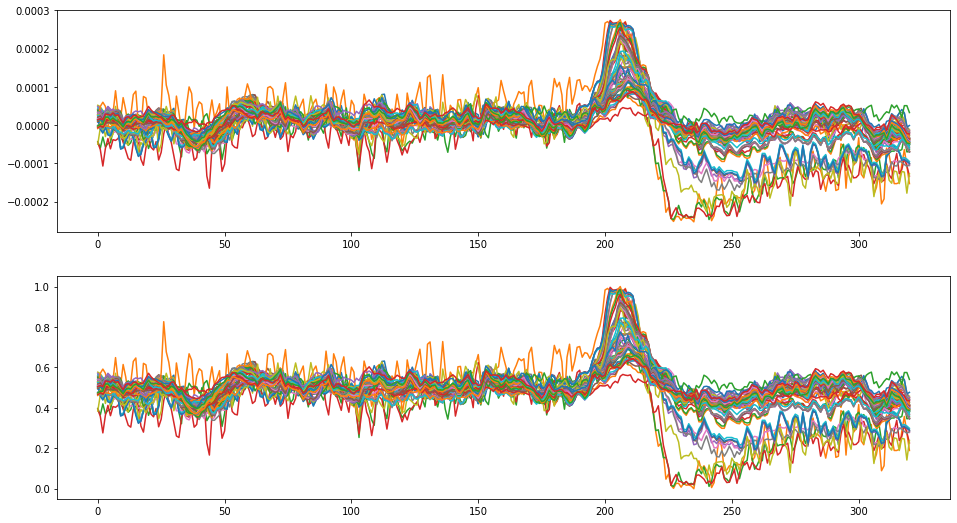

In [3]:
import matplotlib.pyplot as plt
plt.figure(figsize = (20, 8))
# target = 200
# print(y[target])
fig, axs = plt.subplots(2,1, figsize=(16,9))
axs[0].plot(x_before_norm, label = 'raw before normalize')
axs[1].plot(x_after_norm, label = 'raw after normalize')
plt.show()

## TRAIN WITH ALL CHANNEL WITH DIFFERENCE CLASSIFIER

In [4]:

from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from tensorflow.keras.applications.inception_resnet_v2 import InceptionResNetV2 
from sklearn.metrics import classification_report, confusion_matrix
from model_set import EEGNet, HopefulNet1DCNN, SugiyamaNet, TakahashiNet

learning_rate = 1e-4
def eegnet_train(X, y, x_val, y_val, x_test, y_test, verbose = False):
    tf.keras.utils.set_random_seed(SEED)
    # tf.config.experimental.enable_op_determinism()
    classifier_optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    classifier_loss = tf.keras.losses.CategoricalCrossentropy()
    
    # clf = SugiyamaNet(Chans = X.shape[1], Samples = X.shape[2], output_classes = y.shape[1])
    clf = EEGNet(y.shape[1], Chans = X.shape[1], Samples = X.shape[2], 
                                            dropoutRate = 0.5, kernLength = 128, F1 = 16, 
                                            D = 16, F2 = 32, norm_rate = 0.25, dropoutType = 'Dropout')
    
    clf.compile(optimizer = classifier_optimizer, loss= classifier_loss , metrics=['accuracy'])
    
    checkpointer = tf.keras.callbacks.ModelCheckpoint(filepath='tmp/ckpt_eegnet.h5', verbose=False, save_best_only=True)
    earlystopper = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0.001, patience=6, verbose=0)
    clf.fit(X, y,
            batch_size=32, 
            epochs = 100, 
            verbose = verbose, 
            validation_data = (x_val, y_val),
            callbacks = [checkpointer, earlystopper])
    y_preds = clf.predict(x_test, verbose = verbose)
    predicted = np.argmax(y_preds, axis=1)
    ground_truth = np.argmax(y_test, axis=1)
    
    r = accuracy_score(ground_truth, predicted)
    # clf.save('temp_model')
    return r

def ournet_train(X, y, x_val, y_val, x_test, y_test, verbose = False):
    tf.keras.utils.set_random_seed(SEED)
    # tf.config.experimental.enable_op_determinism()
    classifier_optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    classifier_loss = tf.keras.losses.CategoricalCrossentropy()
    
    clf = SugiyamaNet(Chans = X.shape[1], Samples = X.shape[2], output_classes = y.shape[1])
    # clf = EEGNet(y.shape[1], Chans = X.shape[1], Samples = X.shape[2], 
                                            # dropoutRate = 0.5, kernLength = 128, F1 = 16, 
                                            # D = 16, F2 = 32, norm_rate = 0.25, dropoutType = 'Dropout')
    
    clf.compile(optimizer = classifier_optimizer, loss= classifier_loss , metrics=['accuracy'])
    
    checkpointer = tf.keras.callbacks.ModelCheckpoint(filepath='tmp/ckpt_eegnet.h5', verbose=False, save_best_only=True)
    earlystopper = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0.001, patience=6, verbose=0)
    clf.fit(X, y,
            batch_size=32, 
            epochs = 100, 
            verbose = verbose, 
            validation_data = (x_val, y_val),
            callbacks = [checkpointer, earlystopper])
    y_preds = clf.predict(x_test, verbose = verbose)
    predicted = np.argmax(y_preds, axis=1)
    ground_truth = np.argmax(y_test, axis=1)
    
    r = accuracy_score(ground_truth, predicted)
    # clf.save('temp_model')
    return r

def one_d_cnn_train(X, y, x_val, y_val, x_test, y_test, verbose = False):
    tf.keras.utils.set_random_seed(SEED)
    # tf.config.experimental.enable_op_determinism()
    classifier_optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    classifier_loss = tf.keras.losses.CategoricalCrossentropy()
    
    # clf = SugiyamaNet(Chans = X.shape[1], Samples = X.shape[2], output_classes = y.shape[1])
    clf = HopefulNet1DCNN(chs=X.shape[-1], samples=X.shape[1], output_classes = y.shape[1])
    
    clf.compile(optimizer = classifier_optimizer, loss= classifier_loss , metrics=['accuracy'])
    
    checkpointer = tf.keras.callbacks.ModelCheckpoint(filepath='tmp/ckpt_1dcnn.h5', verbose=False, save_best_only=True)
    earlystopper = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0.001, patience=6, verbose=0)
    clf.fit(X, y,
            batch_size=32, 
            epochs = 100, 
            verbose = verbose, 
            validation_data = (x_val, y_val),
            callbacks = [checkpointer, earlystopper])
    y_preds = clf.predict(x_test, verbose = verbose)
    predicted = np.argmax(y_preds, axis=1)
    ground_truth = np.argmax(y_test, axis=1)
    
    r = accuracy_score(ground_truth, predicted)
    # clf.save('temp_model')
    return r

def res101v2_train(X, y, x_val, y_val, x_test, y_test, verbose = False):
    tf.keras.utils.set_random_seed(SEED)
    # tf.config.experimental.enable_op_determinism()
    classifier_optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    classifier_loss = tf.keras.losses.CategoricalCrossentropy()
    
    # clf = SugiyamaNet(Chans = X.shape[1], Samples = X.shape[2], output_classes = y.shape[1])
    # clf = HopefulNet1DCNN(chs=X.shape[-1], samples=X.shape[1], output_classes = y.shape[1])
    print(X.shape)
    clf = tf.keras.applications.resnet_v2.ResNet101V2(include_top=True,weights=None, input_shape=(x_train.shape[1], x_train.shape[2], 1),
                        classes = y.shape[1], classifier_activation = 'softmax')
    
    clf.compile(optimizer = classifier_optimizer, loss= classifier_loss , metrics=['accuracy'])
    
    checkpointer = tf.keras.callbacks.ModelCheckpoint(filepath='tmp/ckpt_res101v2.h5', verbose=False, save_best_only=True)
    earlystopper = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0.001, patience=6, verbose=0)
    clf.fit(X, y,
            batch_size=32, 
            epochs = 100, 
            verbose = verbose, 
            validation_data = (x_val, y_val),
            callbacks = [checkpointer, earlystopper])
    y_preds = clf.predict(x_test, verbose = verbose)
    predicted = np.argmax(y_preds, axis=1)
    ground_truth = np.argmax(y_test, axis=1)
    
    r = accuracy_score(ground_truth, predicted)
    # clf.save('temp_model')
    return r


def kfold(x, y, xt, yt, func, folds = 7):

    f1 = []
    acc = []
    # print(x.shape)  
    r = np.array([])
    kfold = StratifiedKFold(n_splits = folds, shuffle = True, random_state = SEED) #fold
    for i , (train, val) in enumerate(kfold.split(x, np.argmax(y, axis = 1))):
        # tf.random.set_seed(SEED)
        print(f"training on fold {i + 1}")
        res = func(x[train], y[train], x[val], y[val],xt, yt)
        r = np.append(r, res)
    
    tf.keras.backend.clear_session()
    return r.mean(), r.std(), r

In [5]:
#EEGNet
eeg_result = kfold(np.expand_dims(x_train, -1), y_train, np.expand_dims(x_test, -1), y_test, eegnet_train)
eeg_result

training on fold 1


2023-03-09 15:41:24.669661: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:966] could not open file to read NUMA node: /sys/bus/pci/devices/0000:07:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-03-09 15:41:24.703717: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:966] could not open file to read NUMA node: /sys/bus/pci/devices/0000:07:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-03-09 15:41:24.704177: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:966] could not open file to read NUMA node: /sys/bus/pci/devices/0000:07:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-03-09 15:41:24.705470: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate

training on fold 2


2023-03-09 15:52:40.000460: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 735310848 exceeds 10% of free system memory.
2023-03-09 15:52:40.430952: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 735310848 exceeds 10% of free system memory.


training on fold 3


2023-03-09 16:03:38.339520: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 735310848 exceeds 10% of free system memory.


training on fold 4
training on fold 5
training on fold 6
training on fold 7


(0.49466338259441706,
 0.011262221315573195,
 array([0.49329502, 0.48659004, 0.48754789, 0.49521073, 0.48371648,
        0.52011494, 0.49616858]))

In [6]:
one_d_result = kfold(x_train, y_train, x_test, y_test, one_d_cnn_train)
one_d_result

training on fold 1
training on fold 2
training on fold 3
training on fold 4
training on fold 5
training on fold 6
training on fold 7


(0.5778598795840175,
 0.018128620866643887,
 array([0.60632184, 0.57183908, 0.58237548, 0.56896552, 0.55938697,
        0.60057471, 0.55555556]))

In [7]:
ournet_result = kfold(np.expand_dims(x_train.transpose(0,2,1), -1), y_train, np.expand_dims(x_test.transpose(0,2,1), -1), y_test, ournet_train)
ournet_result

training on fold 1
training on fold 2
training on fold 3
training on fold 4
training on fold 5
training on fold 6
training on fold 7


(0.6672140120415982,
 0.006183428312914628,
 array([0.6743295 , 0.66858238, 0.66283525, 0.66475096, 0.66858238,
        0.67528736, 0.65613027]))

In [8]:
res101v2_result = kfold(np.expand_dims(x_train, -1), y_train, np.expand_dims(x_test, -1), y_test, res101v2_train)
res101v2_result 

training on fold 1
(8948, 321, 64, 1)
training on fold 2
(8948, 321, 64, 1)
training on fold 3
(8948, 321, 64, 1)
training on fold 4
(8949, 321, 64, 1)
training on fold 5
(8949, 321, 64, 1)
training on fold 6
(8949, 321, 64, 1)
training on fold 7
(8949, 321, 64, 1)


(0.5351669403393541,
 0.025128011569357456,
 array([0.50191571, 0.55076628, 0.55651341, 0.55938697, 0.55651341,
        0.52394636, 0.49712644]))

In [9]:
np.unique(np.argmax(y_train, 1), return_counts=True)

(array([0, 1, 2, 3, 4]), array([2088, 2088, 2088, 2088, 2088]))